# Interactive Viz - load dataset

After the usually library imports, we load the P3 dataset. We remark that, because of problems in reading the csv file, we have converted the original .csv dataset as an excel spreadsheet.

In [1]:
import pandas as pd

In [2]:
# load excel spreadsheet
data = pd.read_excel('P3.xlsx')
data = data.set_index('Project Number')
#data.head(5)

We check if the project number is actually a unique identifier, as declared in the SNSF P3 website.

In [3]:
data.index.is_unique

True

Since it is unique, we set it as the index of the dataframe. We explore now the dataframe parameters, in order to understand which of them are interesting for our purposes:

In [4]:
data.columns

Index(['Project Title', 'Project Title English', 'Responsible Applicant',
       'Funding Instrument', 'Funding Instrument Hierarchy', 'Institution',
       'University', 'Discipline Number', 'Discipline Name',
       'Discipline Name Hierarchy', 'Start Date', 'End Date',
       'Approved Amount', 'Keywords'],
      dtype='object')

A complete description of the parameters can be found at http://p3.snf.ch/Pages/DataAndDocumentation.aspx. The attributes which are interesting for us are:
+ '**University**': academic insitution where the project is carried out
+ '**Approved Amount**': grant for the project (CHF)

We will consider later also the '**Start Date**' and the '**End date**' parameters for further investigations which take time into account.

Let us filter the dataset, save its reduced version as an .xlsx file.

In [7]:
data_red = data[['University','Approved Amount','Start Date','End Date']]
data_red.head(5)

,University,Approved Amount,Start Date,End Date
Project Number,,,,
1,Nicht zuteilbar - NA,11619.00,01.10.1975,30.09.1976
4,Université de Genève - GE,41022.00,01.10.1975,30.09.1976
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.00,01.03.1976,28.02.1985
6,Universität Basel - BS,52627.00,01.10.1975,30.09.1976
7,"NPO (Biblioth., Museen, Verwalt.) - NPO",120042.00,01.01.1976,30.04.1978


In [8]:
data_red.to_excel('Grants.xlsx',sheet_name='Sheet1')

From now on, we will work on the reduced dataset, which is lighter to load and read. You can start directly from the following section.

# Preliminar data exploration

In this section we will explore the essential features of the dataset.

In [146]:
import pandas as pd
import numpy as np
import seaborn as sbr
import matplotlib.pyplot as plt
%matplotlib inline

We know *a priori* the structure of the dataset, and in particular have experienced that some University fields are filled with NaN, while other rows contain some specification string, such as for instance "*Nicht zuteilbar - NA*", that is, 'not available'. Moreover, when the grant amount is not given, one can find the specification "*data not included in P3*". Since in this case we are not able to treat this data and link them to their corresponding Cantons, we decided to drop them out of the dataset. This is a quite reasonable but significative choice, as the invalid values are roughly the **20%** of the whole dataset.

In [110]:
data = pd.read_excel('Grants.xlsx',sheet_name='Sheet1',na_values=['Nicht zuteilbar - NA','data not included in P3','NaN'])
data = data.set_index('Project Number')
data.head(3)

,University,Approved Amount,Start Date,End Date
Project Number,,,,
1,NaN,11619.0,01.10.1975,30.09.1976
4,Université de Genève - GE,41022.0,01.10.1975,30.09.1976
5,"NPO (Biblioth., Museen, Verwalt.) - NPO",79732.0,01.03.1976,28.02.1985


We convert the grant amounts from string to floating point numbers, in order to treat them quantitatively.

In [111]:
data['Approved Amount']=data['Approved Amount'].astype(float)

Before dropping out any invalid value, we take a look at the original data distribution by plotting the grants amount versus the project number, which is significantly related to the starting date (and then has a temporal meaning).

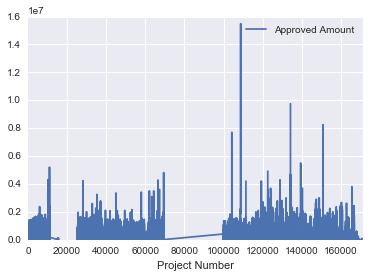

In [112]:
data.plot(y='Approved Amount',use_index=True)

We can observe that there are two *extremely significant gaps* in the data collection. This is maybe due to the fact that the '**Project Number**' is not continuously increasing with the numerical index in the dataset, so we cannot conclude anything by now. We notice also the presence of some **outliers** - corresponding to peaks of about 10 million chf - probably due to projects which have required many years for being developed. This outliers seem to be more frequent as the project number increases, that is in the latest years. After a parsing operation of the date parameters, we will be able to identify the corresponding time slabs when these peaks and data gaps occur.

We have now a look at the consistency of the single dataframe attributes.

In [116]:
# University
nans = data['University'].isnull().value_counts()
print(str(nans[True]/nans.sum())+' Nans ratio out of '+str(nans.sum())+' projects')

0.243492941894 Nans ratio out of 63969 projects


There are roughly **24%** of NaN values in the field '**University**', which will make problematic the matching with the corresponding Canton.

In [115]:
# Grants
nans = data['Approved Amount'].isnull().value_counts()
print(str(nans[True]/nans.sum())+' Nans ratio out of '+str(nans.sum())+' projects')

0.170551360815 Nans ratio out of 63969 projects


The percentage of invalid grants data is about **17%**.

We will now convert the date fields from strings into datetime format, in order to better process them and link the grants to their temporal evolution.

In [156]:
from datetime import datetime
data['Start Date'] = pd.to_datetime(data['Start Date'], format="'%d.%m.%y'",errors='ignore')
data['End Date'] = pd.to_datetime(data['End Date'], format="'%d.%m.%y'",errors='ignore')

In [157]:
data['Start Date'].isnull().value_counts()

False    63968
True         1
Name: Start Date, dtype: int64

Notice that there is one NaN value in the data field (Project Number: 35737). We do not want to wipe it out, since there are informations concerning both the grant and the University.

We plot now the amount of grants with respect to time.

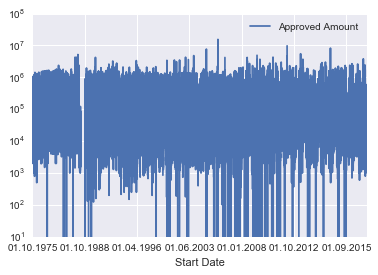

In [191]:
data.plot(x='Start Date',y='Approved Amount',logy=1)

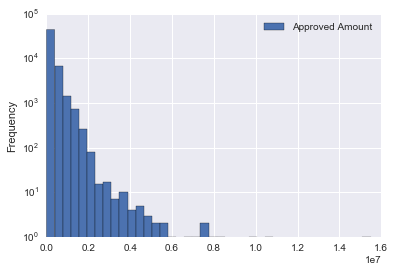

In [222]:
data.plot(x='Start Date',y='Approved Amount',kind='hist',logy=True,bins=40)

As we can see from the plot, the gaps obtained while plotting the grants versus the Project Number are disappeared, because the non-continuity of the index is not related to a time slab in which there are missing data. However, it seems that there is a little gap around the 1980s, but it does not appear problematic.

We proceed not with the elimination of NaN values in the fields '**University**' and '**Approved Amount**', which would make the missing data untreatable.

In [164]:
data_red = data.dropna(subset=['University','Approved Amount'])

In [169]:
print('Percentage of removed data: ' + str(1-len(data_red)/len(data)) )

Percentage of removed data: 0.24521252481670808


Notice that we have removed almost the **25%** of the dataset, but however only null values have been dropped out, so that the statistical properties of the dataset are invariant.

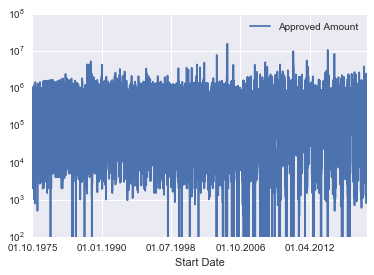

In [194]:
# plot the data in logarithmic scale and the statistical distribution
data_red.plot(x='Start Date',y='Approved Amount',logy=1)

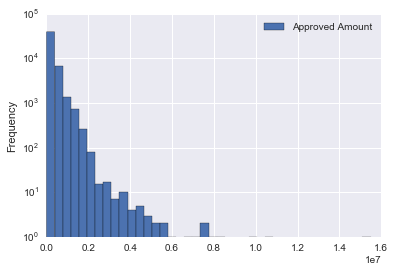

In [221]:
data_red.plot(x='Start Date',y='Approved Amount',kind='hist',logy=True,bins=40)

The distribution of the dataset seems not to follow a power law, since the general behaviour is non linear, or it could be only for law values of grants, because of a heavy tail at high values. We save now the reduced dataset for the real purpose of this analysis, which is to build a clorophlet map using this information.

In [223]:
data_red.to_excel('P3.xlsx')